# Image Search

This notebook demonstrates how to build an image-based recommender system that finds the most similar images to a query image using the nomic-ai/nomic-embed-vision-v1.5 embedding model.

## Step 1: Install Required Packages

In [1]:
#!pip install sentence-transformers torch torchvision pillow matplotlib numpy requests zipfile36

## Step 2: Import Libraries

In [2]:
import os
import requests
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import glob

## Step 3: Download and Unzip Shoes Dataset

In [4]:
# Download shoes.zip if it doesn't exist
if not os.path.exists('shoes.zip'):
    print("Please place shoes.zip in the current directory")
    print("Current directory:", os.getcwd())
else:
    print("Found shoes.zip")

# Unzip the dataset
if not os.path.exists('shoes'):
    with zipfile.ZipFile('shoes.zip', 'r') as zip_ref:
        zip_ref.extractall('.')
    print("Extracted shoes.zip")
else:
    print("Shoes folder already exists")

Found shoes.zip
Extracted shoes.zip


## Step 4: Load Image Paths and Display Sample Images

In [6]:
# Get all image paths from the shoes folder
image_extensions = ['*.jpg']
image_paths = []
for ext in image_extensions:
    image_paths.extend(glob.glob(os.path.join('shoes', '**', ext), recursive=True))

print(f"Found {len(image_paths)} images")

Found 254 images


In [63]:
import random



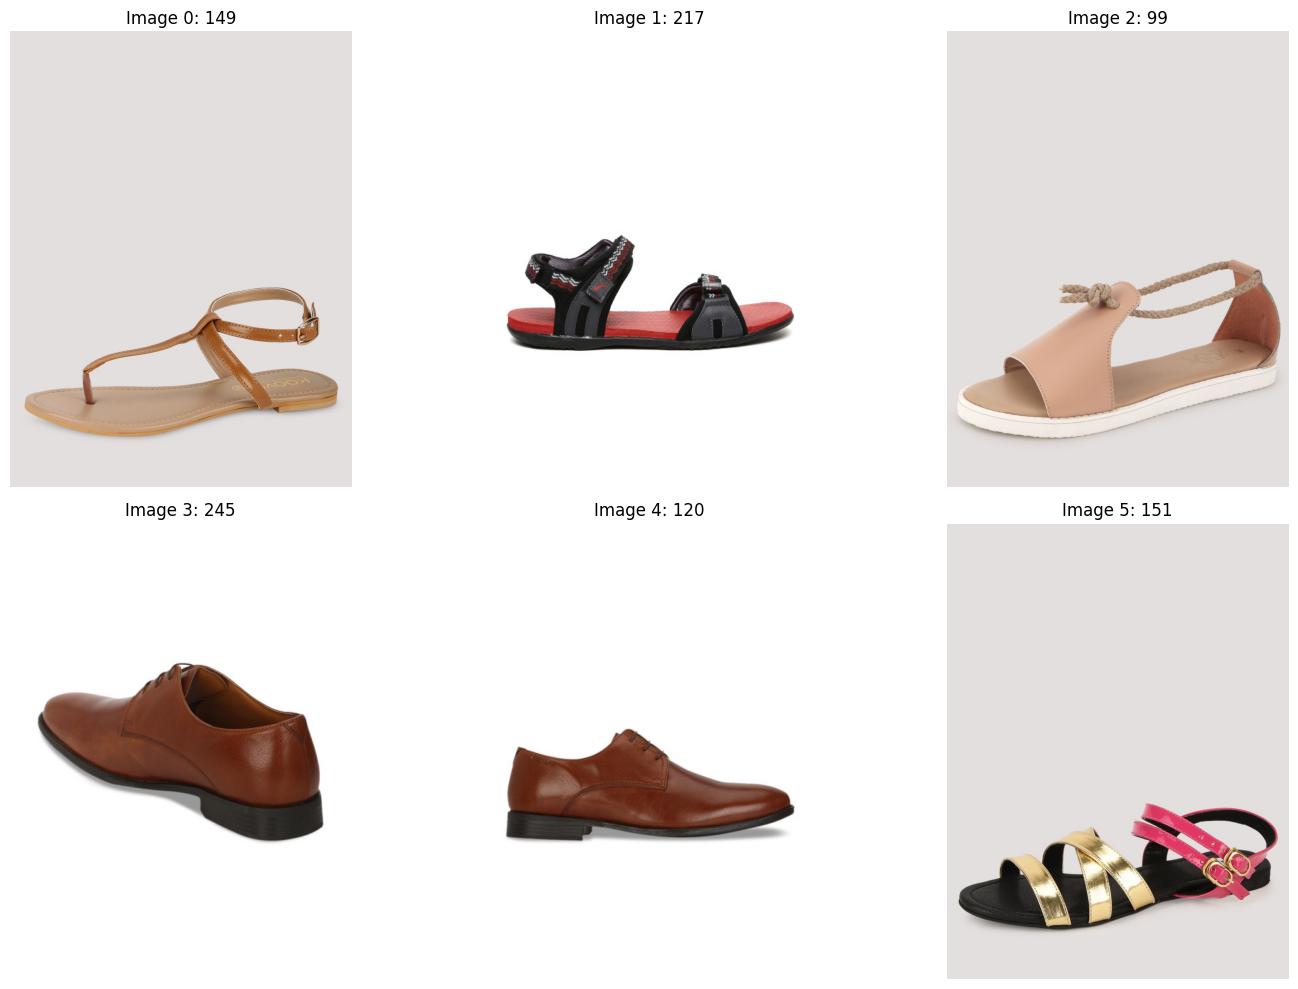

In [68]:
r_images = random.sample(range(1, 255), 6)
# Display first 6 images as samples
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i in range(min(6, len(image_paths))):
    img = Image.open(image_paths[r_images[i]])
    row = i // 3
    col = i % 3
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"Image {i}: {r_images[i]}")
    axes[row, col].axis('off')

# Hide empty subplots
for i in range(6, 6):
    if i < 6:
        row = i // 3
        col = i % 3
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## Step 5: Load the Nomic Vision Embedding Model

In [15]:
# Load the nomic vision embedding model
model = SentenceTransformer("clip-ViT-B-32")
#print("Loaded nomic-embed-vision-v1.5 model")

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

0_CLIPModel/model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Step 6: Compute Embeddings for All Images

In [16]:
# Compute embeddings for all images
print("Computing embeddings for all images...")
embeddings = []

for i, img_path in enumerate(image_paths):
    if i % 10 == 0:
        print(f"Processing image {i+1}/{len(image_paths)}")

    try:
        # Load and encode the image
        img = Image.open(img_path).convert('RGB')
        embedding = model.encode(img)
        embeddings.append(embedding)
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        # Add a zero embedding for failed images
        embeddings.append(np.zeros(768))  # Assuming 768-dim embeddings

# Convert to numpy array
embeddings_array = np.array(embeddings)
print(f"Created embeddings array with shape: {embeddings_array.shape}")

Computing embeddings for all images...
Processing image 1/254
Processing image 11/254
Processing image 21/254
Processing image 31/254
Processing image 41/254
Processing image 51/254
Processing image 61/254
Processing image 71/254
Processing image 81/254
Processing image 91/254
Processing image 101/254
Processing image 111/254
Processing image 121/254
Processing image 131/254
Processing image 141/254
Processing image 151/254
Processing image 161/254
Processing image 171/254
Processing image 181/254
Processing image 191/254
Processing image 201/254
Processing image 211/254
Processing image 221/254
Processing image 231/254
Processing image 241/254
Processing image 251/254
Created embeddings array with shape: (254, 512)


## Step 7: Interactive Recommendation - Try Different Query Images

In [80]:
def get_recommendations(i):
  # Try a different query image - just change the query_index and run this cell
  query_index = i  # Change this to try different images
  k = 4  # Number of recommendations

  # Load query image
  query_image_path = image_paths[query_index]
  query_image = Image.open(query_image_path).convert('RGB')

  # Get query embedding and find similar images
  query_embedding = embeddings_array[query_index].reshape(1, -1)
  similarities = cosine_similarity(query_embedding, embeddings_array)[0]
  similar_indices = np.argsort(similarities)[::-1][:k+1]
  similar_indices = [idx for idx in similar_indices if idx != query_index][:k]

  # Display results
  fig, axes = plt.subplots(1, k+1, figsize=(4*(k+1), 6))

  # Query image
  axes[0].imshow(query_image)
  axes[0].set_title(f"Query Image (Index {query_index})",
                  fontsize=10, fontweight='bold')
  axes[0].axis('off')
  axes[0].add_patch(plt.Rectangle((0, 0), query_image.width-1, query_image.height-1,
                                  fill=False, edgecolor='red', linewidth=3))

  # Recommendations
  for i, idx in enumerate(similar_indices):
      img = Image.open(image_paths[idx]).convert('RGB')
      axes[i+1].imshow(img)
      similarity_score = similarities[idx]
      axes[i+1].set_title(f"Rec {i+1} (Idx {idx})\nSim: {similarity_score:.3f}",
                        fontsize=9)
      axes[i+1].axis('off')

  plt.tight_layout()
  plt.show()

  print(f"\nQuery Index: {query_index}")
  print(f"Recommended indices: {similar_indices}")
  #print(f"Similarity scores: {[similarities[idx]:.3f for idx in similar_indices]}")

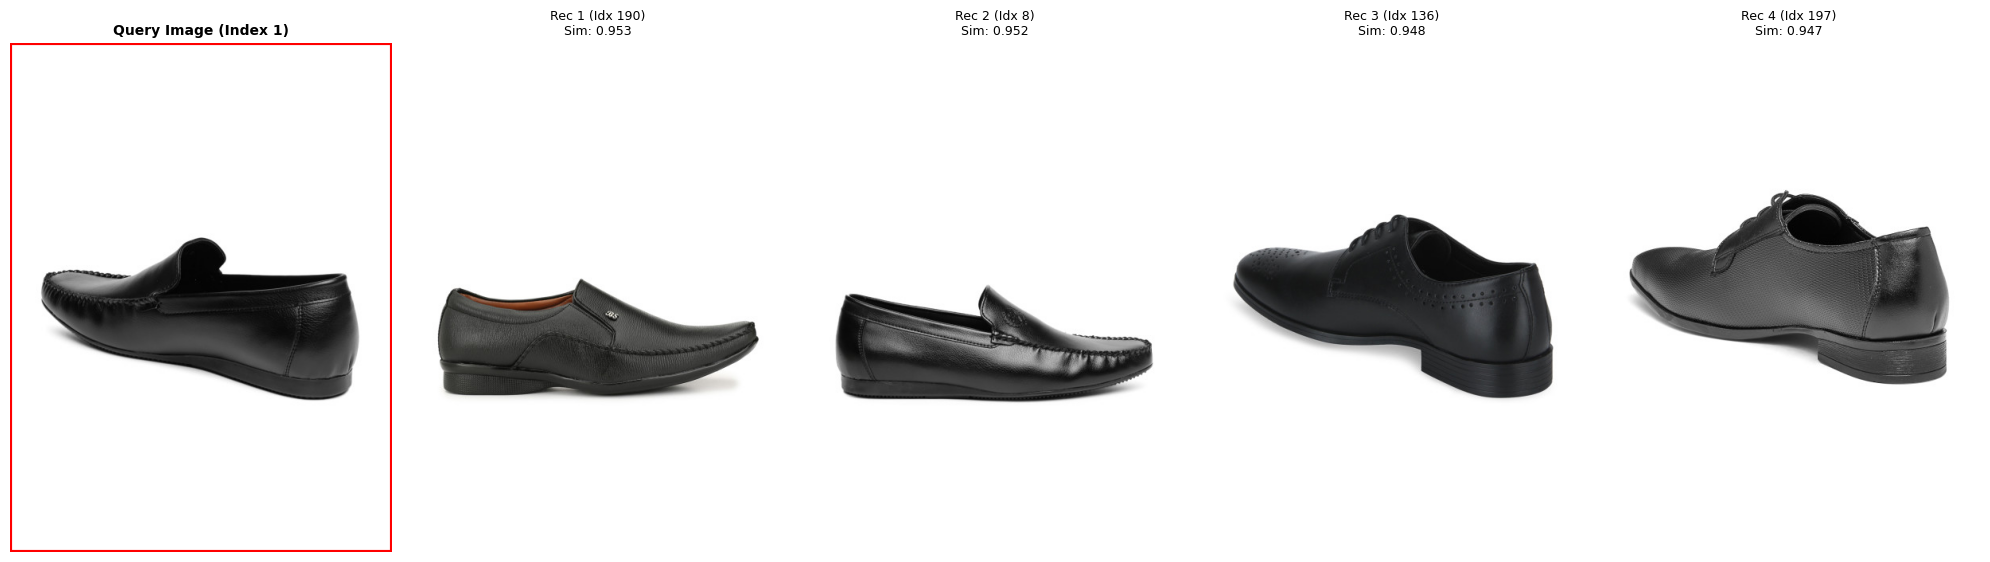


Query Index: 1
Recommended indices: [np.int64(190), np.int64(8), np.int64(136), np.int64(197)]


In [81]:
get_recommendations(1)

## Summary

This notebook demonstrates a complete image-based recommender system:

1. **Data Loading**: Downloaded and extracted the shoes dataset
2. **Embedding Generation**: Used nomic-embed-vision-v1.5 to create embeddings for all images
3. **Similarity Search**: Implemented cosine similarity to find the most similar images
4. **Visualization**: Created horizontal grids showing query images alongside recommendations

To try different query images, simply change the `query_index` variable in the last cell and run it again. The system will find and display the most similar images based on visual features extracted by the embedding model.